# Explore minibatch size
The purpose of this notebook is to explore the effect of many different minibatch size has on model performance. 

As seen in the plot, for data like iris dataset where the data points are homogenous, large minibatch size actually doesn’t help, small batch size learns the fastest with similar test performance. But for applications like cat pictures, each picture looks different and larger minibatch size will actually help.

In [1]:
# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: Batch training in action
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [2]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [3]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

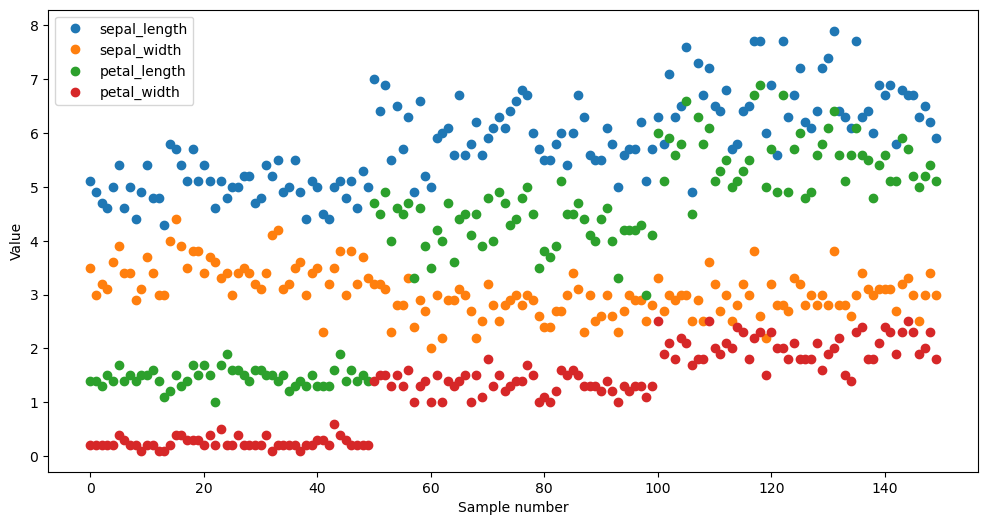

In [4]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [5]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

In [6]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Construct the model and training plans

In [7]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.001)

  return ANNiris,lossfun,optimizer

In [8]:
# train the model

# global parameter
numepochs = 2500

def trainTheModel():

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses


# Test it out

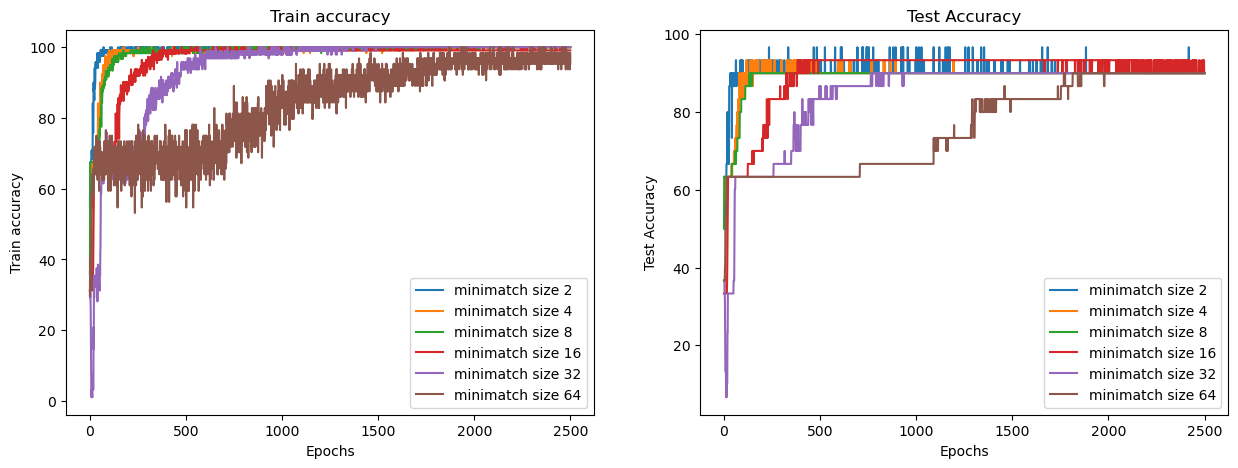

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
minibatch_sizes = [2, 4, 8, 16, 32, 64]
for batchsize in minibatch_sizes:
    # finally, translate into dataloader objects
    batchsize    = batchsize
    train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) 
    # create a model
    ANNiris,lossfun,optimizer = createANewModel()

    # train the model
    trainAcc,testAcc,losses = trainTheModel()

    # make the plot
    ax[0].plot(trainAcc, label = f'minimatch size {batchsize}')
    ax[0].set_ylabel('Train accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_title('Train accuracy')
    ax[0].legend()

    ax[1].plot(testAcc, label = f'minimatch size {batchsize}')
    ax[1].set_title('Test Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Test Accuracy')
    ax[1].legend()

plt.show()